 - existing spreadsheet:
https://docs.google.com/spreadsheets/d/1oM2EL-qs4kX5eJTzWqtekrP4sQ9FjPVVhtAdj8VnyF8/edit?gid=0#gid=0

 - Fall TMP Summary:
https://docs.google.com/spreadsheets/d/1bo3x-BIhXbfH_VPGEHR9VmEH4awP7fnlIMDRIPuiXOk/edit?gid=0#gid=0


 - This is what I propose for project tracking beyond the existing spreadsheet:
  - Add TPM and Partnership info where its missing
  - Add Core member info (its not codified on the doc)
  - Add theme info (Health, Sustainability, Pure CS and "other" etc)
  - Add TPM/Core member discord info
  - Github repo
  - Link to paper
  - program + term
  - uw email/gmail
  - Create a searchable visualization where projects that match the keywords get highlighted + shows how projects are connected to each other (this could be added to the website). I am working with wat.ai to create a viz of our projects. I'm also adding interactivity of the nodes using this https://pyvis.readthedocs.io/en/latest/tutorial.html with lgic based on https://github.com/ansonyuu/matchmaking. The viz does umap dimensionality reduction to miniLLM embeded project abstracts



#Package Setup

## Installations

In [1]:
!pip install umap-learn
!pip install sentence-transformers
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.1 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


## Imports

In [13]:
import csv
import umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import pyvis
from pyvis.network import Network
import numpy as np
import seaborn as sns
import branca.colormap as cm
import branca
import pandas as pd
import re
from textwrap import wrap
import json

project_path = '/content/drive/MyDrive/Clubs/WAT.AI - Zoning LLM Project/0. WatAI_visualizer/'

# Visualization Creation Process

## Create Embeddings from Raw Data

In [9]:
# Read attendees and their responses from a CSV file, replace attendees.csv with own link or file name
attendees_map = {}
with open(project_path+ 'WAT.ai Project Summary - Sheet1.csv', newline='') as csvfile:
    attendees = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(attendees)  # Skip the header row
    for row in attendees:
        name, paragraph = row
        attendees_map[paragraph] = name

# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)

# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Reducing dimensionality of embedding data, scaling to coordinate domain/range


In [10]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)


## Create Visualization Image

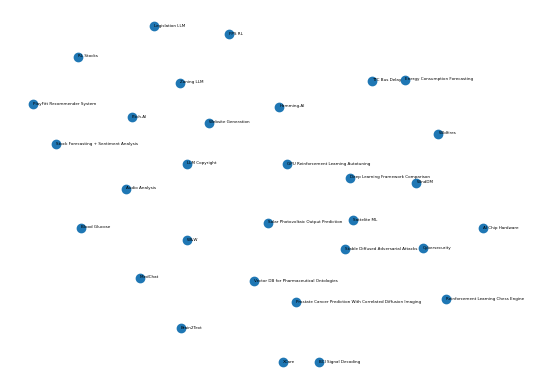

In [11]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig(project_path+'a_visualization.png', dpi=800)

## Find the  top N matches to a node

In [19]:
# Providing top matches
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
        all_personal_pairs[person].append([spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]), person1])

n = 5
# Collect the top n most similarity nodes
data_day_list = []
for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1] # drop yourself, take top 5
    a = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1]
    mini_df = pd.DataFrame(a, columns=['Weight', 'Target'])
    mini_df['Source'] = person
    data_day_list.append(mini_df)

# output this information as a json
with open(project_path + 'b_top5_matches.json', 'w') as json_file:
    json.dump(top_matches, json_file)

# Output this information as a csv
df = pd.concat(data_day_list)
df.to_csv(project_path + 'b_top5_matches.csv')


## Add Colour/Paragraph Information to Dataframe

In [20]:
# Get the colour pallette
colour = sns.color_palette("pastel",len(x)).as_hex()

# Add colour pallette to the df
df1 = pd.DataFrame([label,colour])
df1 = df1.T
df1.rename(columns={0: 'Source', 1: 'Colour'},inplace=True)
df = df.set_index('Source').join(df1.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)

# Add colour pallette for both the df Target and Source:
df1.rename(columns={'Source': 'Target'},inplace=True)
df = df.set_index('Target').join(df1.set_index('Target'),lsuffix='_Source', rsuffix='_Target')
df['Target'] = df.index
df = df.reset_index(drop=True)
print(df)

# Add paragraphs to the df
df2 = pd.DataFrame([label,paragraphs])
df2 = df2.T
df2.rename(columns={0: 'Source', 1: 'Paragraphs'},inplace=True)
df = df.set_index('Source').join(df2.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)
print(df)

# Create a cleaned Dataframe of just the Source and and Paragraph information
df_new = df[["Source","Paragraphs"]]
df_new = df_new.drop_duplicates()
df_new.set_index('Source', inplace=True)

       Weight Colour_Source                               Source  \
0    0.768095       #ffb482                  BCI Signal Decoding   
1    0.656813       #debb9b                        Cybersecurity   
2    0.627010       #fffea3   Deep Learning Framework Comparison   
3    0.678690       #fffea3       Energy Consumption Forecasting   
4    0.584004       #b9f2f0  Reinforcement Learning Chess Engine   
..        ...           ...                                  ...   
150  0.712111       #d0bbff                           Hamming.AI   
151  0.694269       #ff9f9b                        LLM Copyright   
152  0.667441       #8de5a1                     Legislation LLM    
153  0.771096       #b9f2f0                             MedChat    
154  0.805539       #ffb482                   Website Generation   

    Colour_Target            Target  
0         #cfcfcf  AI Chip Hardware  
1         #cfcfcf  AI Chip Hardware  
2         #cfcfcf  AI Chip Hardware  
3         #cfcfcf  AI Chip Hard

## Build Interative Network Visualization (Simple)

In [23]:
# Intitalize bucket size and colour palettes
buckets = [100] * len(x)
colour = sns.color_palette("pastel",len(x)).as_hex()

# Initialize network
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add unconnected nodes to the network
g.add_nodes(list(range(1,len(x)+1)), value=buckets,
                         title=paragraphs,
                         x=np.array(x).astype(np.float64),
                         y=np.array(y).astype(np.float64),
                         label=label,
                         color=colour)

# Output the visualization
g.toggle_physics(True)
g.show(project_path+'c_simple_viz.html', notebook=False)

/content/drive/MyDrive/Clubs/WAT.AI - Zoning LLM Project/0. WatAI_visualizer/c_simple_viz.html


## Build Interative Network Visualization (Complex)


In [24]:
# Initialize network
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",select_menu=True,cdn_resources='remote')

# Create a dictionary of Important information
sources = df['Source']
targets = df['Target']
weights = df['Weight']
color_targets = df['Colour_Target']
color_sources = df['Colour_Source']

edge_data = zip(sources, targets, weights,color_targets,color_sources)

# Add nodes and edges to the network
for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]
                c_t= e[3]
                c_s= e[4]
                got_net.add_node(src, src, title=src,color=c_s)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)#,color = "#c79910") # if you  want a solide colour for edges

# Add paragraphs to the popup
for i,node in enumerate(got_net.nodes):
               content =df_new.loc[node.get("title"),"Paragraphs"]
               node["title"] += ": "+ "\n \n" +'\n'.join(wrap(content, width=50))

## Output the visualization
got_net.show(project_path+'c_complex_viz.html', notebook=False)

/content/drive/MyDrive/Clubs/WAT.AI - Zoning LLM Project/0. WatAI_visualizer/c_complex_viz.html
